# 19기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


**반응 변수(결과: 예측하고자 하는 값)**
+ Purchase

## 1. Preprocssing / EDA

In [4]:
df.isna().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [5]:
df.isna().sum()/len(df)
# Product_Category_2 , Product_Category_3의 경우 결측치의 비율이 높아 제외 

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.306723
Product_Category_3            0.691076
Purchase                      0.000000
dtype: float64

In [6]:
# 고유값 'User_ID', 'Product_ID' 제외
# 결측치 존재 'Product_Category_2', 'Product_Category_3' 제외

df.drop(columns=['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3'], inplace = True)

In [7]:
#수치형 변수
df.describe(include='number')

,Occupation,Marital_Status,Product_Category_1,Purchase
count,4998.000000,4998.000000,4998.000000,4998.000000
mean,8.036815,0.421369,5.320128,9234.655462
std,6.442697,0.493828,3.912281,4999.225081
min,0.000000,0.000000,1.000000,13.000000
25%,2.000000,0.000000,1.000000,5497.750000
50%,7.000000,0.000000,5.000000,8049.000000
75%,14.000000,1.000000,8.000000,12039.000000
max,20.000000,1.000000,20.000000,23913.000000


In [8]:
print(df['Occupation'].value_counts())
print(df['Marital_Status'].value_counts())
print(df['Product_Category_1'].value_counts())

# Purchase 제외 수치형 변수들은 사실상 category인 것을 확인할 수 있음
# target 변수 : Purchase

4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18
Name: Occupation, dtype: int64
0    2892
1    2106
Name: Marital_Status, dtype: int64
5     1407
1     1285
8      995
2      227
11     206
3      193
6      193
4      107
16      78
15      57
13      43
10      41
7       40
12      31
20      31
19      20
14      19
18      18
17       6
9        1
Name: Product_Category_1, dtype: int64


In [9]:
#범주형 변수 ( 문자열인 경우 )
df.describe(include='O')

,Gender,Age,City_Category,Stay_In_Current_City_Years
count,4998,4998,4998,4998
unique,2,7,3,5
top,M,26-35,B,1
freq,3765,1996,2102,1758


In [10]:
target = df['Purchase']
df = pd.concat([pd.get_dummies(df.iloc[:,:-1]), target], axis = 1)
df

,Occupation,Marital_Status,Product_Category_1,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,...,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Purchase
0,10,0,5,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,2010
1,10,0,7,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,4483
2,10,0,1,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,7696
3,10,0,2,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,16429
4,10,0,3,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,5780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,7,1,1,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,11701
4994,1,1,8,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,2045
4995,13,1,1,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,4505
4996,0,1,12,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1413


In [11]:
X = df.drop(['Purchase'], axis=1)
y = df['Purchase']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3998, 20)
X_test shape: (1000, 20)
y_train shape: (3998,)
y_test shape: (1000,)


## 2. KNN 구현 & 파라미터 튜닝

In [12]:
# 탐색해볼 K 리스트:1~100 사이의 홀수 값들
k_list = [i for i in range(1, 100, 2)] 
train_accuracy = []
test_accuracy = []

for k in tqdm(k_list):
    knn = KNeighborsRegressor(n_neighbors = k)
    # p=1: manhattan_distance, p=2: euclidean_distance, # p=l_p: minkoski_distance
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))     
    test_accuracy.append(knn.score(X_test, y_test))
    
    # [ Classifier 인 경우 ]
    # classifier = KNeighborsClassifier(n_neighbors = k, p=2)
    # 10-cross validation으로 탐색
    # scores: k값마다 10개의 값 누적 
    # scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    
    # scores의 평균을 k값 마다의 성능 평가 결과로 사용
    # cv_scores.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


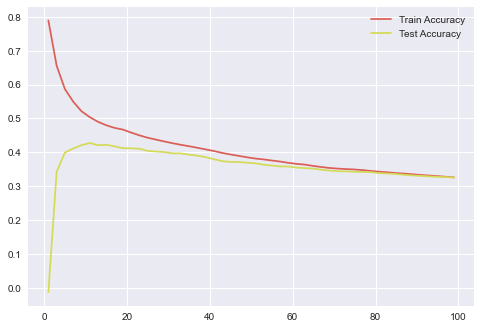

In [13]:
import matplotlib.pyplot as plt

plt.plot(k_list, train_accuracy, label = "Train Accuracy")
plt.plot(k_list, test_accuracy, label = "Test Accuracy")
plt.legend()
plt.show()

In [14]:
pd.Series(test_accuracy).sort_values(ascending=False).head(10)

5     0.427318
7     0.422099
4     0.420954
6     0.420667
8     0.417197
9     0.411874
10    0.411563
3     0.410991
11    0.410256
12    0.404031
dtype: float64

## 3. Evaluation

In [15]:
k_list = [i for i in range(1, 20, 2)] 
for i in k_list:
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, y_train)
    print(i,'test score : {:.3f}'.format(knn.score(X_test, y_test)))

1 test score : -0.014
3 test score : 0.342
5 test score : 0.399
7 test score : 0.411
9 test score : 0.421
11 test score : 0.427
13 test score : 0.421
15 test score : 0.422
17 test score : 0.417
19 test score : 0.412


In [16]:
knn = KNeighborsRegressor(n_neighbors = 11)
knn.fit(X_train, y_train)
print('test score : {:.3f}'.format(knn.score(X_test, y_test)))

test score : 0.427


In [17]:
results = knn.predict(X_test)

In [18]:
pd.crosstab(y_test, results, rownames=['Real'], colnames=['Predicted'], margins=True, margins_name='total')

Predicted,568.0909090909091,600.7272727272727,723.0909090909091,838.7272727272727,943.0,1223.0,1535.5454545454545,1652.909090909091,1820.6363636363637,2285.3636363636365,...,15919.0,16043.09090909091,16204.181818181818,16210.818181818182,16596.909090909092,16658.909090909092,16823.272727272728,16857.18181818182,16947.727272727272,total
Real,,,,,,,,,,,,,,,,,,,,,
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
